In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from time import time
from tqdm import tqdm
import numpy as np

import xarray as xr
# import torchvision

import optax
import jax.numpy as jnp
import jax.tree_util as jtu
import jax
import flax.linen as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [3]:
class NeRFReLU(nn.Module):
    n_hidden_layer_neurons: list
    output_shape: int
    
    @nn.compact
    def __call__(self, x, y):
        x = jnp.concatenate([x, y], axis=-1)
        x = nn.Dense(self.n_hidden_layer_neurons[0])(x)
        x = nn.relu(x)
        for i in range(1, len(self.n_hidden_layer_neurons)):
            x = nn.Dense(self.n_hidden_layer_neurons[i])(x)
            x = nn.relu(x)
        x = nn.Dense(self.output_shape)(x)
        return x
    
class NeRFReLUQuad(nn.Module):
    n_hidden_layer_neurons: list
    output_shape: int
    
    @nn.compact
    def __call__(self, x, y):
        x = jnp.concatenate([x, y], axis=-1)
        x1 = nn.Dense(self.n_hidden_layer_neurons[0])(x)
        x2 = nn.Dense(self.n_hidden_layer_neurons[0])(x)
        x = nn.relu(x1 * x2 + x1)

        for i in range(1, len(self.n_hidden_layer_neurons)):
            x1 = nn.Dense(self.n_hidden_layer_neurons[i])(x)
            x2 = nn.Dense(self.n_hidden_layer_neurons[i])(x)
            x = nn.relu(x1 * x2 + x1)
        x = nn.Dense(self.output_shape)(x)
        return x
    
# define initializers
def first_layer_init(key, shape, dtype=jnp.float32):
    num_input = shape[0]  # reverse order compared to torch
    return jax.random.uniform(key, shape, dtype, minval=-1.0/num_input, maxval=1.0/num_input)

def other_layers_init(key, shape, dtype=jnp.float32):
    num_input = shape[0]  # reverse order compared to torch
    return jax.random.uniform(key, shape, dtype, minval=-np.sqrt(6 / num_input)/30, maxval=np.sqrt(6 / num_input)/30)

class NeRFSine(nn.Module):
    n_hidden_layer_neurons: list
    output_shape: int
    
    @nn.compact
    def __call__(self, x, y):
        x = jnp.concatenate([x, y], axis=-1)
        x = nn.Dense(self.n_hidden_layer_neurons[0], kernel_init=first_layer_init, bias_init=first_layer_init)(x)
        x = jnp.sin(30*x)
        for i in range(1, len(self.n_hidden_layer_neurons)):
            x = nn.Dense(self.n_hidden_layer_neurons[i], kernel_init=other_layers_init, bias_init=other_layers_init)(x)
            x = jnp.sin(30*x)
        x = nn.Dense(self.output_shape, kernel_init=other_layers_init, bias_init=other_layers_init)(x)
        return x
    
def fit(key, model, train_x, train_y, lr, iterations):
    train_x = jtu.tree_map(jnp.asarray, train_x)
    train_y = jtu.tree_map(jnp.asarray, train_y)
    
    # initialize params
    params = model.init(key, *train_x)

    # loss fun
    def loss_fn(params, x, y, key):
        y_hat = model.apply(params, *x, rngs={'dropout': key})
        loss = jnp.mean((y - y_hat)**2)
        return loss
    value_and_grad_fn = jax.value_and_grad(loss_fn)

    optimizer = optax.adam(lr)
    state = optimizer.init(params)

    # lax scan loop
    @jax.jit
    def one_step(params_and_state, key):
        params, state = params_and_state
        value, grads = value_and_grad_fn(params, train_x, train_y, key)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state), value

    keys = jax.random.split(key, iterations)
    (params, state), losses = jax.lax.scan(one_step, (params, state), xs=keys)
    return {'params': params, 'losses': losses}

## Reconstruction

original shape: (682, 1024, 1)
scaled shape: (341, 512, 1)


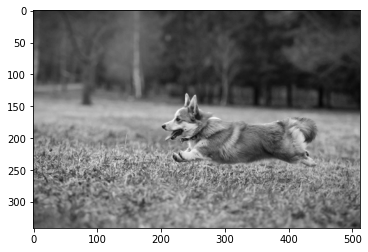

In [5]:
img = plt.imread("../data/images/dog_2.jpg")
img = img.mean(axis=2, keepdims=True)
img = img / 255.0

# initial scaling
initial_factor = 2
img = nn.avg_pool(img, window_shape=(initial_factor, initial_factor), strides=(initial_factor, initial_factor))

# scale down image by factor of 2
factor = 2
print(f"original shape: {img.shape}")
scaled_img = nn.avg_pool(img, window_shape=(factor, factor), strides=(factor, factor))
print(f"scaled shape: {scaled_img.shape}")

plt.imshow(scaled_img, cmap='gray');

In [7]:
X, Y = jnp.meshgrid(np.linspace(-1, 1, scaled_img.shape[1]), np.linspace(-1, 1, scaled_img.shape[0]))
X, Y = X[..., None], Y[..., None]
print(X.shape, Y.shape, scaled_img.shape)

siren = NeRFSine(n_hidden_layer_neurons=[256]*4, output_shape=img.shape[-1])
nerf_relu = NeRFReLU(n_hidden_layer_neurons=[256]*4, output_shape=img.shape[-1])
# nerf_relu_quad = NeRFReLUQuad(n_hidden_layer_neurons=[256]*4, output_shape=img.shape[-1])
models = {'siren': siren, 
          'relu': nerf_relu, 
        #   'relu_quad': nerf_relu_quad
          }

key = jax.random.PRNGKey(1)

# train
results = jtu.tree_map(lambda model: fit(key, model, (X, Y), scaled_img, 1e-4, 5000), models)

(341, 512, 1) (341, 512, 1) (341, 512, 1)


relu loss: 0.003945425618439913
siren loss: 0.00010244813893223181


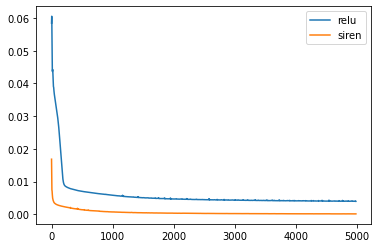

In [8]:
offset = 10
for model, values in results.items():
    print(f"{model} loss: {values['losses'][-1]}")
    plt.plot(values['losses'][offset:], label=model)
plt.legend();

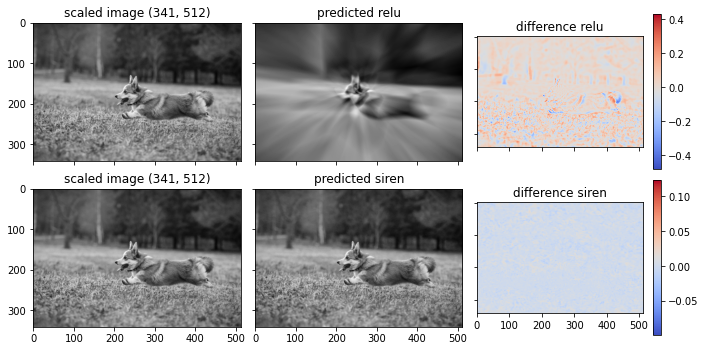

In [15]:
n_models = len(models.keys())
fig, ax = plt.subplots(n_models, 3, figsize=(10, 3.4*n_models), sharex=True, sharey=True)
ax = ax.reshape(len(models.keys()), 3)
for i, (model_name, values) in enumerate(results.items()):
    pred_img = models[model_name].apply(values['params'], X, Y)
    ax[i, 0].imshow(scaled_img, cmap='gray')
    ax[i, 0].set_title(f"scaled image {scaled_img.shape[:2]}")

    ax[i, 1].imshow(pred_img, cmap='gray');
    ax[i, 1].set_title(f"predicted {model_name}");

    mappable = ax[i, 2].imshow(scaled_img - pred_img, cmap='coolwarm');
    ax[i, 2].set_title(f"difference {model_name}");
    fig.colorbar(mappable, ax=ax[i, 2]);

plt.tight_layout(rect=[0, 0, 1, 0.7]);

(681, 1023, 1) (681, 1023, 1) (682, 1024, 1)


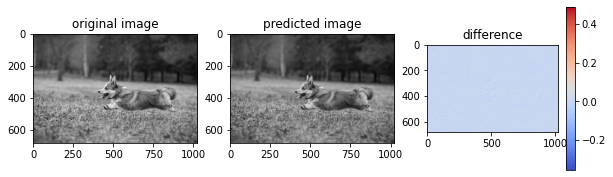

In [8]:
X_new, Y_new = jnp.meshgrid(np.linspace(-1, 1, img.shape[1]-1), np.linspace(-1, 1, img.shape[0]-1))
X_new, Y_new = X_new[..., None], Y_new[..., None]
print(X_new.shape, Y_new.shape, img.shape)

trained_params = results['siren']['params']
pred_img = models['siren'].apply(trained_params, X_new, Y_new)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("original image")

ax[1].imshow(pred_img, cmap='gray');
ax[1].set_title("predicted image");

mappable = ax[2].imshow(img[:-1,:-1,:] - pred_img, cmap='coolwarm');
ax[2].set_title("difference");
fig.colorbar(mappable, ax=ax[2]);